# Analysis of the impact of weather on energy consumption of Delhi 
### Author: Avikal Somvanshi

##### National Capital Territory (NCT) of Delhi is a political and administrative unit of the union of India comprising of New Delhi, the capital city of India, and its urban extentions. According to 2011 Census of India it had a population of 16.8 million. Delhi doesn't have heavy industry and agriculture which are dominant consumers of electricity at national level yet it is consuming more electricity than any of the following individual states: Himachal Pradesh, Jammu & Kashmir, Uttarakhand, Chhattisgarh, Goa, Kerala, Bihar, Jharkhand, Odisha, Sikkim and all states of the North-east. Delhi’s residential energy consumption is makes up more than 52 per cent of electicity consumed in the city-state. The total energy consumed by Delhi households is more than that of all households in Gujarat, one of the richest states, with a population about three times that of Delhi. 
##### Delhi is also known to exhibit higher seasonal variation in it electricity consumption compared to the national average. The month with the highest electricity consumption in Delhi accounts for 104 per cent more consumption than in the lowest consumption month, while at national level this number is just 15 per cent (LGBR 2017-18). 

#### Research Questions: How is the electricity consumption in Delhi is linked to outdoor thermal conditions? How much of the electricity consumed in the city is for maintaining thermal comfort requirements?

##### Data: Daily electricity consumption data is sourced from the monthly reports of the State Load Dispatch Center, Delhi, the apex body which ensures integrated operation of Delhi’s power system. Data is from 1-1-2010 to 31-3-2018 (manually entered into an excel sheet). The India Meteorological Department(IMD) weather station at Indira Gandhi International Airport is the source of the weather data, it has been scraped from wunderground.com. 
##### Degree days was used as one of the measure of thermal conditions outdoors. Its is a measure of cooling or heating need on a given day based on how many degrees the daily mean temperature of a day is above (cooling) or below (heating) the comfort band. The study used 18-23oC as comfort range, below 18oC is heating season and above 23oC is cooling season.
##### The heat index (HI) or humiture is the other measure of thermal conditions outdoors. It is an index that combines air temperature and relative humidity, in shaded areas, to posit a human-perceived equivalent temperature, as how hot it would feel if the humidity were some other value in the shade. For this study, daily HI was calculated with daily maximum temperature and average relative humidity for the given day.

In [1]:
#Importing packages
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats
import datetime as dt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# loading electricity data
erg = pd.read_excel('data/Delhi_Daily_Energy_2010_18.xlsx')
erg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 11 columns):
Date                           3012 non-null datetime64[ns]
Consumption_MUS                2922 non-null float64
Peak_Demand_MW                 2924 non-null float64
Time_PD_HRS                    2924 non-null object
Shedding_PD_MW                 2922 non-null float64
UNRESTRICTED_DEMAND_MW         2922 non-null float64
MAX_UNRESTRICTED_ DEMAND_MW    2922 non-null float64
TIME_MAX_URD_HRS               2922 non-null object
DEMAND_AT_MAX_URD_MW           2922 non-null float64
SHEDDING_MAX_URD_MW            2922 non-null float64
Time_PD                        3012 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(2)
memory usage: 258.9+ KB


In [3]:
# uploading weather data
weather = pd.read_csv('data/Delhi_Weather_Data_Daily_2006_18.csv')
#converting date column to datetime 
weather['Date'] = pd.to_datetime(weather.Date)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473 entries, 0 to 4472
Data columns (total 10 columns):
Unnamed: 0    4473 non-null int64
Min_Temp      4473 non-null int64
Mean_Temp     4473 non-null int64
Max_Temp      4473 non-null int64
Avg_RH        4473 non-null int64
Rain          4473 non-null int64
HI            4473 non-null float64
CDD           4473 non-null int64
HDD           4473 non-null int64
Date          4473 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 349.5 KB


In [4]:
#merging the energy and weather data
df = pd.merge(erg, weather, on = 'Date', how='outer')
df.dropna(inplace=True) # drapping nans
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True) #setting datetime index
df.sort_index(inplace=True)
df.describe()

,Consumption_MUS,Peak_Demand_MW,Shedding_PD_MW,UNRESTRICTED_DEMAND_MW,MAX_UNRESTRICTED_ DEMAND_MW,DEMAND_AT_MAX_URD_MW,SHEDDING_MAX_URD_MW,Unnamed: 0,Min_Temp,Mean_Temp,Max_Temp,Avg_RH,Rain,HI,CDD,HDD
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,75.948453,3969.674880,9.410729,3979.085216,3980.867556,3966.222793,14.645157,2842.486653,19.369268,25.168036,30.955168,60.062628,0.276865,36.651993,4.482204,0.779603
std,19.449155,797.242672,29.503617,802.733750,803.817055,796.292868,49.431419,958.678817,7.798484,7.374292,7.399611,19.606603,2.563071,12.318583,4.485496,1.838392
min,39.551000,2089.000000,0.000000,2106.000000,2106.000000,2089.000000,0.000000,0.000000,1.000000,6.000000,9.000000,13.000000,0.000000,9.000000,0.000000,0.000000
25%,59.489250,3310.250000,0.000000,3312.250000,3313.250000,3307.000000,0.000000,2161.250000,12.000000,18.000000,25.000000,48.000000,0.000000,25.000000,0.000000,0.000000
50%,69.807500,3795.500000,0.000000,3814.000000,3819.000000,3789.000000,0.000000,2891.500000,21.000000,28.000000,32.000000,61.000000,0.000000,37.375319,5.000000,0.000000
75%,91.207250,4547.000000,4.000000,4552.750000,4552.750000,4542.000000,4.000000,3621.750000,26.000000,31.000000,36.000000,74.000000,0.000000,46.432650,8.000000,0.000000
max,130.580000,6261.000000,452.000000,6342.000000,6342.000000,6261.000000,692.000000,4382.000000,35.000000,40.000000,49.000000,100.000000,64.000000,83.170424,17.000000,12.000000


In [40]:
# making a composite degree days column (cooling degree days - heating degree days) negative value implies heating season
df['dd'] = df.CDD - df.HDD

# making a total degree days column (cooling degree days + heating degree days)
df['DD'] = df.CDD + df.HDD

corelation (Pearson) between energy_consumed and degree days is  (0.78336992604633771, 0.0)
corelation (Pearson) between energy_consumed and heat index is  (0.80883965655505285, 0.0)


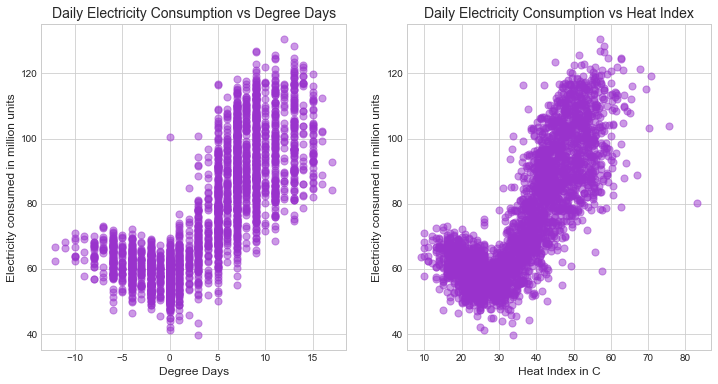

In [45]:
#checking corelation (Pearson)
cor_dd = scipy.stats.pearsonr(df['Consumption_MUS'],(df['dd']))
cor_hi = scipy.stats.pearsonr(df['Consumption_MUS'],(df['HI']))
print 'corelation (Pearson) between energy_consumed and degree days is ', cor_dd
print 'corelation (Pearson) between energy_consumed and heat index is ', cor_hi

#Ploting data Daily Electricity Consumption vs Degree Days and HI
sns.set_style("whitegrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
df.plot(kind='scatter', x='dd', y='Consumption_MUS', color='darkorchid',s=50, alpha=.5, ax=ax1)
ax1.set_title('Daily Electricity Consumption vs Degree Days', fontsize=14)
ax1.set_ylabel("Electricity consumed in million units", fontsize=12)
ax1.set_xlabel("Degree Days", fontsize=12)
df.plot(kind='scatter', x='HI', y='Consumption_MUS', color='darkorchid',s=50, alpha=.5, ax=ax2)
ax2.set_title('Daily Electricity Consumption vs Heat Index', fontsize=14)
ax2.set_ylabel("Electricity consumed in million units", fontsize=12)
ax2.set_xlabel("Heat Index in C", fontsize=12)
pl.show()

#### Figure 1: Total electricity consumed in Delhi in a day his highly correlated with outdoor thermal conditions. It has a 0.78 Pearson correlation coefficient with degree days and 0.81 Pearson correlation coefficient with heat index, implying relative humidity also has impact on the electricity consumption. Visual inspection of the graphs reveals that minimum consumption in the city is recorded when HI is in range 25-30oC which coinsides with the National Building Code of India's prescription that Indians have their thermal comfort is in range of 25-30oC (Tropical Summer Index value). The noise in the data can be attributed to impact of changing population over the years, weekdays-weekends-holidays, wind and rain.

##### Question: What additional test or analysis can be done?

### Computing electricity consumed purely for thermal comfort needs of the city.

##### Thermal comfort needs are not limited to domestic sector, commerical sector which includes offices, retails, educational setups, hospitality among others is also sensetive to thermal conditions. Domestic and commerical sector combined accounted for 75-80 per cent of electricity consumed annually in the city for period 2010-17. Public utilities (water supply, street lighting, etc.) and transportation (Delhi Metro) accounts of another 8-10 per cent of the annual electricity consumption. Rest is consumed by the industry. 

##### Delhi most of the building stock is naturally ventilated or mix-mode (employing air-conditioning or space heating for a limited time during the year) giving building users considerable freedom to switch on or off the space cooling or heating equipment based on their  immediate thermal exposure, readily reflected in variation in peak elecltricity demand with changing weather conditions within a day (Examined and analysed in a different notebook).

##### Buildings with central air-conditioning and heating that run their the thermal comfort systems throughout the year make a considerable portion of the new building stock of the city. Electricity consumption in these buildings is also impacted by external temperature conditions as the energy efficiency of space heating and cooling equipment is directly dependent upon it. Building would have to spend additional energy to keep indoors at standard 24oC when outdoor temperature is 40oC as compared to times when outdoor temperature is 25oC. 

##### Electricity consumed by city utlities and Delhi Metro are expected to remain more or less constant for a given year, as major subheads are water works and streetlighting, demand for which don't tend to vary much.

##### Delhi doesn't have heavy industry and the light industry in the city is largely annual by nature. 

### Methodology 
#### For a given year, electricity consumed on a day with zero degree days is counted as zero electricity consumed for thermal comfort.
#### For a given year, average electricity consumed on days with zero degree days is offsetted from the energy consumed on rest of the days. 

### Assumptions
#### On a day with zero degree days no cooling or heating systems are running in naturally ventilated or mixed mode buildings in the city. Centrally air conditioned buildings are running at their most efficient as there is minimal pressure on the system due to external conditions.
#### Electricity consumed on a day with zero degree days is the baseline energy that the city would consume irrespective of weather conditions.
#### Number of people living and working in the city remains constant for a given year. There is no major change in population of mechinical systems, electronic gadgets, public utlities, industry or transportation for a given year.


In [55]:
# breaking the data according to the year
df10 = df[(df.index.year == 2010)]
df11 = df[(df.index.year == 2011)]
df12 = df[(df.index.year == 2012)]
df13 = df[(df.index.year == 2013)]
df14 = df[(df.index.year == 2014)]
df15 = df[(df.index.year == 2015)]
df16 = df[(df.index.year == 2016)]
df17 = df[(df.index.year == 2017)]
df18 = df[(df.index.year == 2018)]

In [56]:
#computing portion of energy consumed for cooling heating needs
df10d = df10[(df10.dd == 0)] #identifying days with zero degree days
# subtracting average consumption on days with zero degree days from the consumption of each day
df10['offset_erg'] = df10.Consumption_MUS - (df10d.Consumption_MUS.mean())
mask = (df10.dd == 0) #masking all the values with zero degree days
# since hypothesis assumes that no additional energy is consumed for cooling or heating 
# on days with zero degree days, energy consumed on these days is set to zero 
df10.loc[mask, 'offset_erg'] = 0 #replacing all masked entries with zero
df10.offset_erg.loc[df10.offset_erg < 0] = 0 #setting all negative values to zero 
df10['group_month'] = [dt.datetime.strftime(e, '%m') for e in df10.index] # making a month stamp for grouping
df10['group_year'] = [dt.datetime.strftime(e, '%Y') for e in df10.index] # making a year stamp for grouping
df10 = df10[['group_year', 'group_month', 'Consumption_MUS', 'HI', 'dd', 'DD', 'offset_erg']] #retaining relevant columns
gp10 = df10.groupby(by=['group_month', 'group_year']).sum() # grouping data by month
gp10.reset_index(inplace=True) # resetting index
gp10.head() # checking data

C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

,group_month,group_year,Consumption_MUS,HI,dd,DD,offset_erg
0,01,2010,1762.338,564.000000,-147,147,168.492963
1,02,2010,1411.817,709.284025,-21,25,6.370630
2,03,2010,1741.085,1110.472320,112,112,166.827852
3,04,2010,2250.117,1182.073884,293,293,687.351037
4,05,2010,2531.932,1370.102163,362,362,935.758074


In [57]:
#running a for loop for rest of the years
for i in range(2011,2019):
    dff = df[(df.index.year == i)] #slicing the data by year
    #computing portion of energy consumed for cooling heating needs
    dffd = dff[(dff.dd == 0)] #identifying days with zero degree days
    # subtracting average consumption on days with zero degree days from the consumption of each day
    dff['offset_erg'] = dff.Consumption_MUS - (dffd.Consumption_MUS.mean())
    mask = (dff.dd == 0) #masking all the values with zero degree days
    # since hypothesis assumes that no additional energy is consumed for cooling or heating 
    # on days with zero degree days, energy consumed on these days is set to zero 
    dff.loc[mask, 'offset_erg'] = 0 #replacing all masked entries with zero
    dff.offset_erg.loc[dff.offset_erg < 0] = 0 #setting all negative values to zero 
    dff['group_month'] = [dt.datetime.strftime(e, '%m') for e in dff.index] # making a month stamp for grouping
    dff['group_year'] = [dt.datetime.strftime(e, '%Y') for e in dff.index] # making a year stamp for grouping
    dff = dff[['group_year', 'group_month', 'Consumption_MUS', 'HI', 'DD', 'dd', 'offset_erg']] # retaining relevant columns
    gpf = dff.groupby(by=['group_month', 'group_year']).sum() # grouping data by month
    gpf.reset_index(inplace=True) # resetting index
    df10 = pd.concat([df10, dff]) # concating data daily
    gp10 = pd.concat([gp10, gpf]) # concating data monthly

C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Abhikal\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [58]:
gp10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 2
Data columns (total 7 columns):
Consumption_MUS    96 non-null float64
DD                 96 non-null int64
HI                 96 non-null float64
dd                 96 non-null int64
group_month        96 non-null object
group_year         96 non-null object
offset_erg         96 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 6.0+ KB


corelation (Pearson) between Additional energy_consumed and degree days is  (0.8180220705802731, 0.0)
corelation (Pearson) between Additional energy_consumed and heat index is  (0.8336813032406013, 0.0)


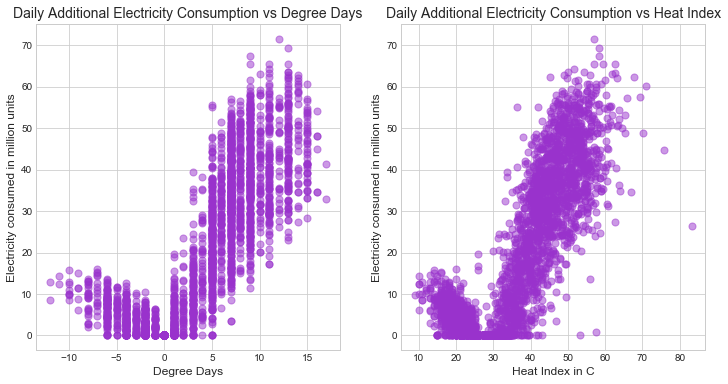

In [60]:
#checking corelation (Pearson) between offsetted electricity consumption and external weather conditions
cor_dd = scipy.stats.pearsonr(df10['offset_erg'],(df10['dd']))
cor_hi = scipy.stats.pearsonr(df10['offset_erg'],(df10['HI']))
print 'corelation (Pearson) between Additional energy_consumed and degree days is ', cor_dd
print 'corelation (Pearson) between Additional energy_consumed and heat index is ', cor_hi

#Ploting data Daily Electricity Consumption vs Degree Days and HI
sns.set_style("whitegrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
df10.plot(kind='scatter', x='dd', y='offset_erg', color='darkorchid',s=50, alpha=.5, ax=ax1)
ax1.set_title('Daily Additional Electricity Consumption vs Degree Days', fontsize=14)
ax1.set_ylabel("Electricity consumed in million units", fontsize=12)
ax1.set_xlabel("Degree Days", fontsize=12)
df10.plot(kind='scatter', x='HI', y='offset_erg', color='darkorchid',s=50, alpha=.5, ax=ax2)
ax2.set_title('Daily Additional Electricity Consumption vs Heat Index', fontsize=14)
ax2.set_ylabel("Electricity consumed in million units", fontsize=12)
ax2.set_xlabel("Heat Index in C", fontsize=12)
pl.show()

#### Figure 2: Additional electricity consumed in Delhi in a day for thermal comfort requirements has higher corelation with external weather condition measures. It has a 0.82 Pearson correlation coefficient with degree days and 0.83 Pearson correlation coefficient with heat index. 

##### Question: What additional test or analysis can be done?

In [74]:
#making a datetime column for monthly data
gp10['date'] = pd.to_datetime((gp10.group_year+gp10.group_month).apply(str),format='%Y%m') 
gp10.head()

,Consumption_MUS,DD,HI,dd,group_month,group_year,offset_erg,date,fit
0,1762.338,147,564.000000,-147,01,2010,168.492963,2010-01-01,472.993618
1,1411.817,25,709.284025,-21,02,2010,6.370630,2010-02-01,475.576306
2,1741.085,112,1110.472320,112,03,2010,166.827852,2010-03-01,478.158993
3,2250.117,293,1182.073884,293,04,2010,687.351037,2010-04-01,480.741681
4,2531.932,362,1370.102163,362,05,2010,935.758074,2010-05-01,483.324368


In [76]:
#checking yearly trend
df10['days'] = 1
gpy = df10.groupby(by=['group_year']).sum()
gpy['offset_per_Dday'] = gpy.offset_erg / gpy.DD
gpy['percent_comfort_eng'] = gpy.offset_erg / gpy.Consumption_MUS
gpy

,Consumption_MUS,DD,HI,dd,offset_erg,days,offset_per_Dday,percent_comfort_eng
group_year,,,,,,,,
2010,22282.159,1947,12148.409945,1413,5089.294259,335,2.613916,0.228402
2011,23625.164,1685,12250.086014,1095,5590.290277,335,3.317680,0.236624
2012,26119.140,1991,12903.923365,1355,6285.264657,366,3.156838,0.240638
2013,26387.617,1919,13399.732973,1325,6736.407048,365,3.510374,0.255287
2014,28959.294,2058,13176.193584,1356,7880.476158,365,3.829192,0.272123
2015,29500.353,1939,13333.968870,1407,8156.780896,365,4.206695,0.276498
2016,30811.123,1967,14597.008042,1657,9225.048105,366,4.689908,0.299406
2017,28368.849,1650,12742.775690,1272,7905.638824,335,4.791296,0.278673
2018,5867.682,219,2545.024540,-61,315.241857,90,1.439461,0.053725


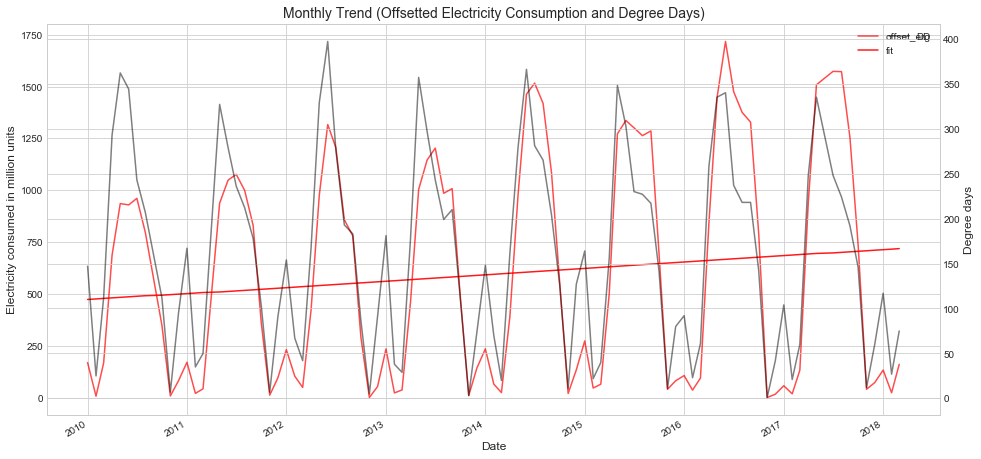

In [71]:
#fitting line to the offsetted electricity consumption data.
x = np.arange(gp10.date.size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
fit = np.polyfit(x, gp10.offset_erg, 1)
fit_fn = np.poly1d(fit)
#saving the prediction 
gp10['fit'] = fit_fn(x)

#Ploting monthly trend
sns.set_style("whitegrid")

ax = pl.figure(figsize=(16,8)).add_subplot(111)
ax2 = ax.twinx()
gp10.plot(x='date', y='offset_erg', color='red',alpha=0.7, ax=ax)
gp10.plot(x='date', y='fit', color='red',alpha=0.9, ax=ax)
gp10.plot(x='date', y='DD', color='k',alpha=0.5, ax=ax2)
ax.set_title('Monthly Trend (Offsetted Electricity Consumption and Degree Days)', fontsize=14)
ax.set_ylabel("Electricity consumed in million units", fontsize=12)
ax2.set_ylabel("Degree days", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
pl.show()

#### Figure 3: Additional electricity consumed in Delhi has a seasonal pattern that mirrors the pattern of degree days distribution across the year. Intensity of electricity consumed per degree day has steadly increase over years growing from 2.6 MUs/DegreeDay in 2010 to 4.8 MUs/DegreeDay in 2017. Overall, additional electricity consumed in the city to maintain thermal comfort conditions indoor is between 25-30 per cent of the total annual electricity consumption of the city.  

##### Note: Data for June 2017 is missing that is making 2017 look similiar to 2016 as June happens to be the month with highest consumption and hottest in the year.

##### Question: What additional test or analysis can be done?

### Conclusion

#### External thermal conditions and arising need for thermal comfort has significant impact on the electricity budget of the city. Growth in electricity consumption is a function of improving household income and increasing population but city's demand of electricity to meet is comfort needs has grown faster than its rate of population and GDP growth. This is signalling electricity guzzling as city buildings are poorly designed to reduce load on HVAC systems that are not efficient to start with. Please read the press-note below for recommendations.  

##### https://www.cseindia.org/cse-releases-its-rating-of-selected-cities-which-manage-and-segregate-their-municipal-waste-most-efficiently-8781